# Implementation of the embeded block residual network (EBRN)

In [1]:
import numpy as np
import tensorflow as tf
import h5py

from os import path, walk, getcwd
from datetime import datetime

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


from DataGenereator import DataGenClass
from EBRN import EBRNClass
from PostProcessing import PostProcClass

In [2]:
#check if any GPU is available
n_gpu = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(n_gpu))

# if a GPU is available the following variable can be set to True
using_gpu = False #True

Num GPUs Available:  0


In [3]:
# tf.debugging.set_log_device_placement(True)
# tf.config.experimental.set_memory_growth(n_gpu[0], True)


In [3]:
now = datetime.now()
t_stamp = now.strftime('%Y%m%d_%H%M%S')

print('================================================================================')
print('******************   Embedded Block Residual Neural Network      ***************')
print('                          ' + now.strftime("%Y-%m-%d %H:%M:%S"))
print()

******************   Embedded Block Residual Neural Network      ***************
                          2020-06-03 15:02:40



In [5]:
# all div2k files for training should be in /.div2k/images folder
# /DIV2K_train_HR
# /DIV2K_valid_HR
# /DIV2K_train_LR_bicubic/X4 
# /DIV2K_valid_LR_bicubic/X4
#...

working_dir = getcwd()
print(working_dir)

DIV_dir = working_dir +'/.div2k'



ckpt_dir = working_dir +'/.ckpt/'
ckpt_filename = 'cp.ckpt'

ckpt_dir_tune = working_dir +'/.ckpt_ft/'
ckpt_filename_tune = 'cp_ft.ckpt'


# filename to save the model via pydot and graphviz
model_fname = 'SR_EBRNet_v02.1.png'

In [6]:
# Run training or reading weights
read_weights = True #False  # weights (cpkt files) should be already stored in .cpkt folder

# start fine-tuning train, weights for previous train shoud be already read
fine_tuning_train = False #True  #  #train with MAE loss function but fune_tuning with MSE loss funcion


In [7]:
# Super-resolution factor
scale_factor = 4

# size of input low resolution image
LR_img_size = 64

# Number of BRM units
n_block = 4

batch_size=32
n_epochs = 400


In [8]:
# learning rate scheduling, start with 0.0001 and divide by 10 every 100 steps

learning_rate_change = {'epoch':[100, 200, 300], 'lr':[1e-04, 1e-05, 1e-06, 1e-07]}


In [9]:
datagen = DataGenClass(scale_factor, LR_img_size, DIV_dir)

hr (n=800) and lr (n=800) images for training.
hr (n=100) and lr (n=100) images for validation.


In [10]:
ds_hr_train = datagen.images_to_dataset(subset='HR_for_train')
        
ds_hr_val = datagen.images_to_dataset(subset='HR_for_val')    
    
ds_lr_train = datagen.images_to_dataset(subset='LR_for_train')

ds_lr_val = datagen.images_to_dataset(subset='LR_for_val')

In [11]:
train_ds = datagen.dataset_to_batch(ds_lr_train, ds_hr_train, batch_size=batch_size, random_transform=True)
valid_ds = datagen.dataset_to_batch(ds_lr_val, ds_hr_val, batch_size=1, random_transform=True, repeat_count=1)

In [12]:
net = EBRNClass(learning_rate_change, fine_tuning_train)
model = net.create_model(n_block, scale_factor, LR_img_size, channel=3)

In [13]:
#EBR problems:
# 1. no Conv for the last BRM. why?
# 2. number of parameters (for x4) are very higher (~23m with 4 BRM) than what is reported in the paper-fig.9 (8m)
# 3. no clear running schadule e.g. epoches? or triane then fine-tuning
# 4. No explanation for Table 1. 

In [13]:

# Check model architecture
model.summary()

# print graph of the model (needs installed graphviz and pydot)
plot_model(model=model, to_file=model_fname, show_shapes=True)

Model: "EBR_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_LR (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 3)    0           input_LR[0][0]                   
__________________________________________________________________________________________________
FE_C1 (Conv2D)                  (None, 64, 64, 256)  1055744     lambda[0][0]                     
__________________________________________________________________________________________________
FE_C2 (Conv2D)                  (None, 64, 64, 64)   409664      FE_C1[0][0]                      
____________________________________________________________________________________________

NameError: name 'plot_model' is not defined

In [15]:
# save best weights only via tf ModelCheckpoint

def training(filepath):
    model_ckpt_callback = ModelCheckpoint(filepath = filepath, monitor='val_loss', mode='auto', 
                                          save_best_only=True, save_weights_only=True, verbose=1)
    if n_gpu !=0 and using_gpu:
        try:
            with tf.device('/device:GPU:0'):
                model_hist = model.fit(train_ds, validation_data=valid_ds, steps_per_epoch= 25, 
                                       callbacks=[model_ckpt_callback], epochs=n_epochs, verbose = 1)
            return model_hist

        except RuntimeError as e: 
            print(e)
    else:
        try:
            with tf.device('/device:CPU:0'):
                model_hist = model.fit(train_ds, validation_data=valid_ds, steps_per_epoch= 25, 
                                       callbacks=[model_ckpt_callback], epochs=n_epochs, verbose = 1)
            return model_hist

        except RuntimeError as e: 
            print(e)

In [16]:
# Load weights (for test or fine tuning) or run training from scratch

if read_weights:
    if path.exists(ckpt_dir_tune+ckpt_filename_tune+'.index'):
        model.load_weights(ckpt_dir+ckpt_filename)
        if fine_tuning_train:
            print('To strat fine tuning train, delete old files in {}'.format(ckpt_dir_tune))
    elif path.exists(ckpt_dir+ckpt_filename+'.index'):
        model.load_weights(ckpt_dir+ckpt_filename)
        if fine_tuning_train:
            training(ckpt_dir_tune+ckpt_filename_tune)
    else:
        print('ckpt files are not exist in the path. To start training change |read_best_weight| to False')
    
else:
    training(ckpt_dir+ckpt_filename)


Executing op RestoreV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/r

In [17]:
print()
print('============================================================================')
now = datetime.now()
print('                           ' + now.strftime("%Y-%m-%d %H:%M:%S"))
print('',flush=True)


                           2020-06-02 20:17:36



In [18]:
ppc = PostProcClass(model, LR_img_size, scale_factor, n_imshow=3)

woman.png [w:228, h:344] was dropped from test list. Min size = (256px by 256px)
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RealDiv in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Conv2D in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BiasAdd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Relu in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Neg in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

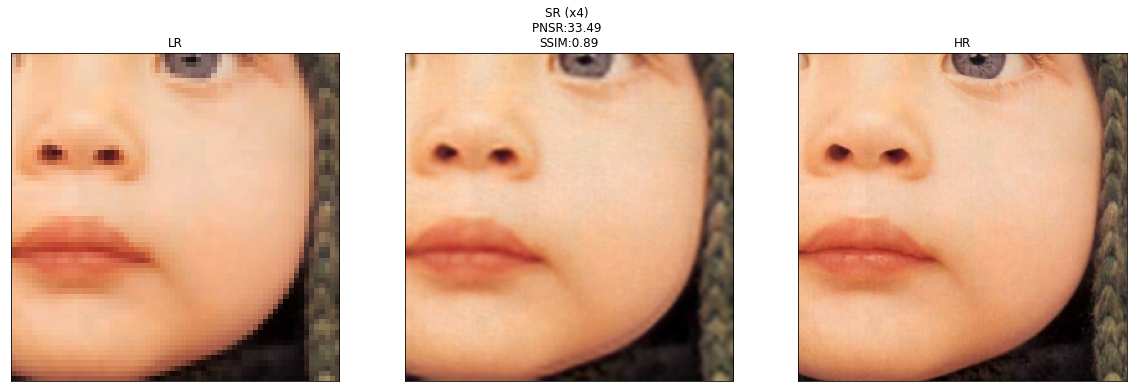

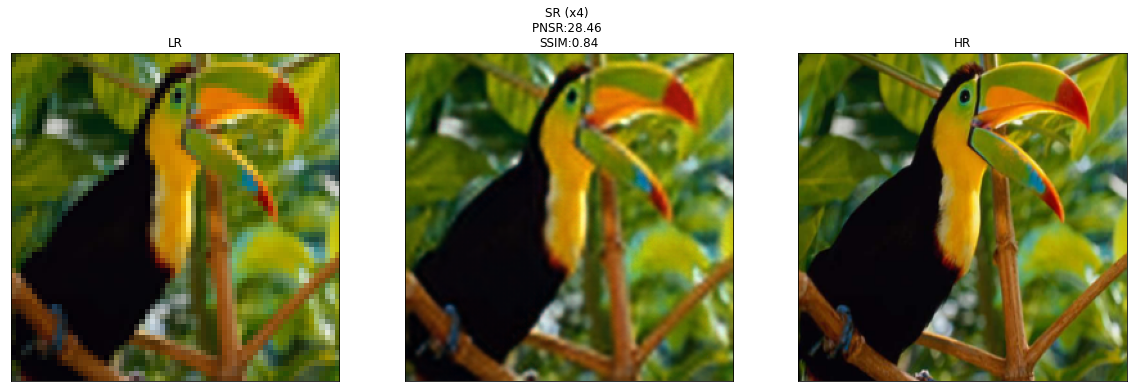

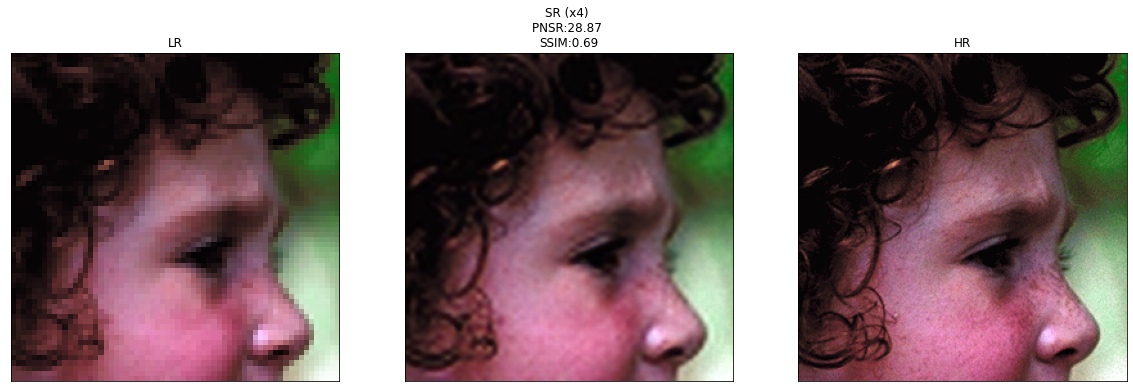

In [19]:
# evalute the network via test datasets like Set5, Set14 or .... They sould be stored in /.testsets folder

indexes = ppc.eval_test_dir(working_dir +'/.testsets/Set5/')

print('****************************************') 
print('\nAverage_PNSR: {} \nAverage_SSIM: {}\nin {} images'.
      format(round(indexes[0],2), round(indexes[1],2), indexes[2]))       
print('****************************************') 


comic.png [w:250, h:361] was dropped from test list. Min size = (256px by 256px)
****************************************

Average_PNSR: 28.22 
Average_SSIM: 0.79
in 4 images
****************************************


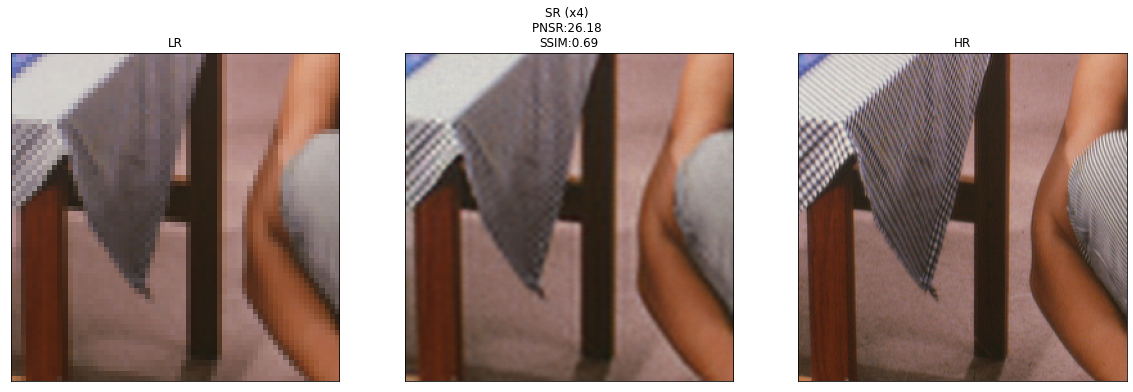

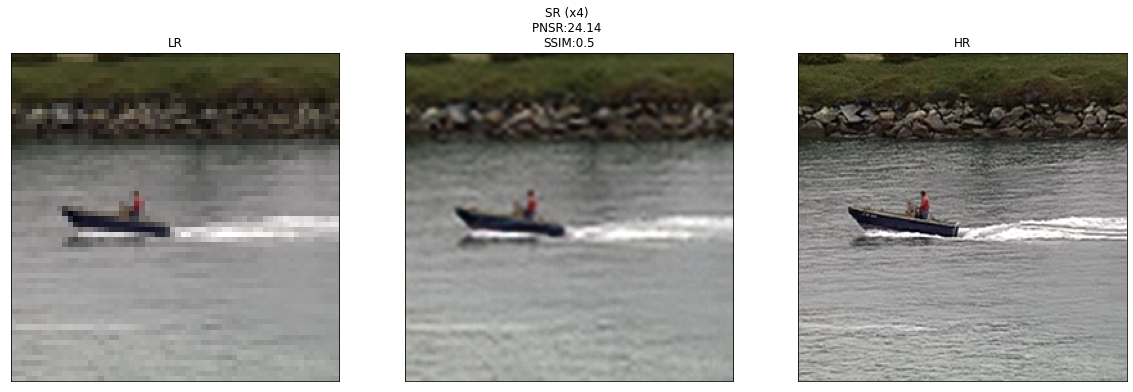

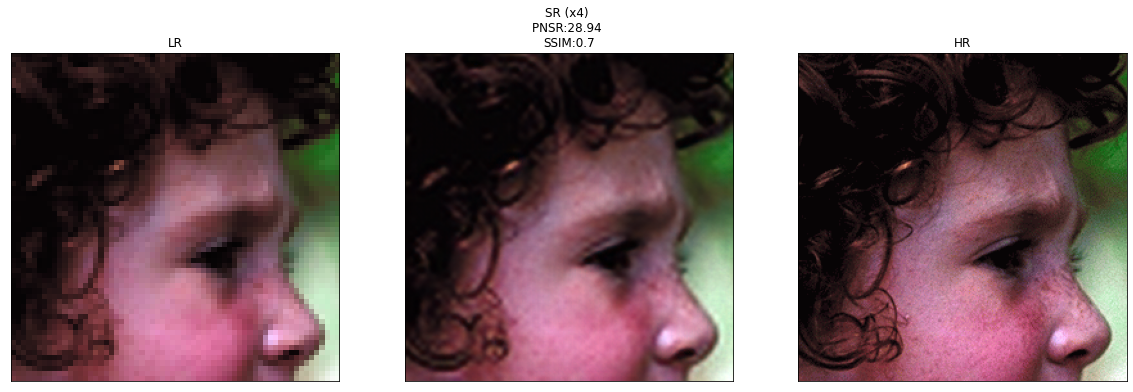

In [20]:
index = ppc.eval_test_dir(working_dir +'/.testsets/Set14/')
print('****************************************') 
print('\nAverage_PNSR: {} \nAverage_SSIM: {}\nin {} images'.
      format(round(indexes[0],2), round(indexes[1],2), indexes[2]))       
print('****************************************') 